# **🤔 What is Image Segmentation?**
> ### Image segmentation is the process of dividing an image into multiple segments, each of which represents a different object or part of an object.**
# **😯 Meta's Segment Anything Model (SAM) is a large language model that has been trained on a massive dataset of images and their segmentation masks. This allows SAM to segment any object in any image, even if it has never seen the object before.**

> # 🤓 **I've used this SAM model with respect to the Self-Driving Car's 🚗 Application where it can help cars to identify and track objects in the environment, which can help prevent collisions.**

# 📥️ **Do the required imports...**

In [15]:
import torch
import torchvision

print("Pytorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the default model from here: 
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth 

import numpy as np
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Pytorch version: 2.0.0
Torchvision version: 0.15.1
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gy5rok3j
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gy5rok3j
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-06-19 16:05:16--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.141.13, 13.249.141.40, 13.249.141.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.141.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   214MB/s    in 10s     

2023-06-19 16:05:26 (245 MB/s) - ‘sam_

# 👀 **Read in the original image**

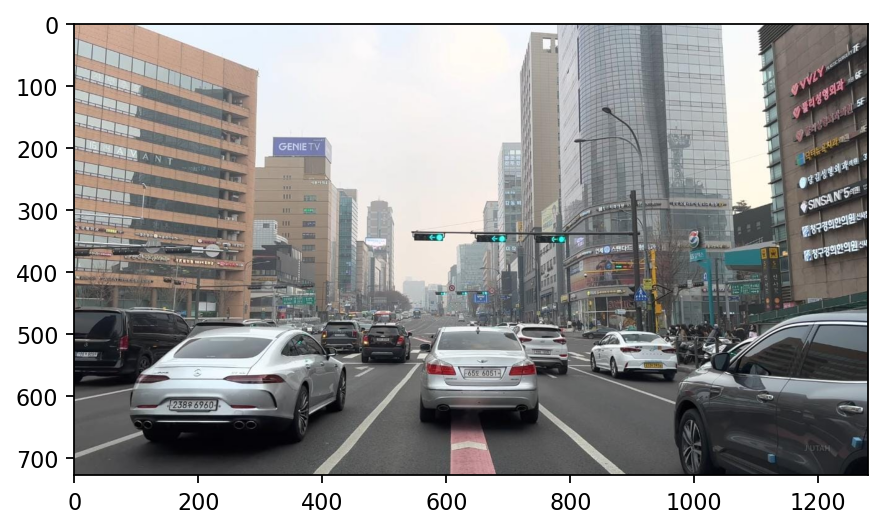

In [16]:
image = cv2.imread('/kaggle/input/cars-image-for-image-segmentation/cars_on_road.jpeg')

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# show the image
plt.figure(dpi=160)
plt.imshow(image)

# ♻️ **Automatic Mask Generation...**

* ### Let's first store the path to a pre-trained model checkpoint (present in kaggle output)

In [17]:
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"

* ### Give the name of the Model Architecture

In [18]:
model_type = "vit_h"

* ### create an instance of SAM model and load pre-trained weights from checkpoint file
> The "sam_model_registry" is a dictionary that maps model types to model classes.

In [19]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

* ### let's check for GPU if available, thereby if present, assigning model to run on GPU

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# 🛠️ **Now, Create an Instance of "SamAutomaticMaskGenerator" class**
> ## To run automatic mask generation, provide SAM model to the "SamAutomaticMaskGenerator" class. Set the path to the SAM checkpoint.The parameters that are passed to the constructor, control the behaviour of "Mask Generator".

> ### 1. **model:** The sam model that is used to generate the masks.

> ### 2. **points_per_side:** The number of points that are used to sample the image.

> ### 3. **pred_iou_thresh:** The threshold that is used to filter masks based on their predicted intersection over union (IoU) score.

> ### 4. **stability_score_thresh:** The threshold that is used to filter masks based on their stability score.

> ### 5.**crop_n_layers:** The number of layers that are used to crop the image.

> ### 6. **crop_n_points_downscale_factor:** The factor that is used to downscale the image before cropping.

> ### 7. **min_mask_region_area:** The minimum area that a mask must have in order to be considered.

# **There are several tunable parameters in automatic mask generation that control:**
1. ### How Densely points are sampled and what the thresholds are for removing low quality or duplicate masks.
2. ### Additionally, generation can be automatically run on crops of the image to get improved performance on similar objects and post-processing can remove stray pixels and holes.

# **Here's an example configuration that samples more masks:**
> ## **https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35**


In [21]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100    # Requires open-cv to run post-processing
)

# ⏩️ |**Generate the mask...**

In [22]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

312
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


# ✏️ **Now let's define a function that Visualizes mask on an Image**

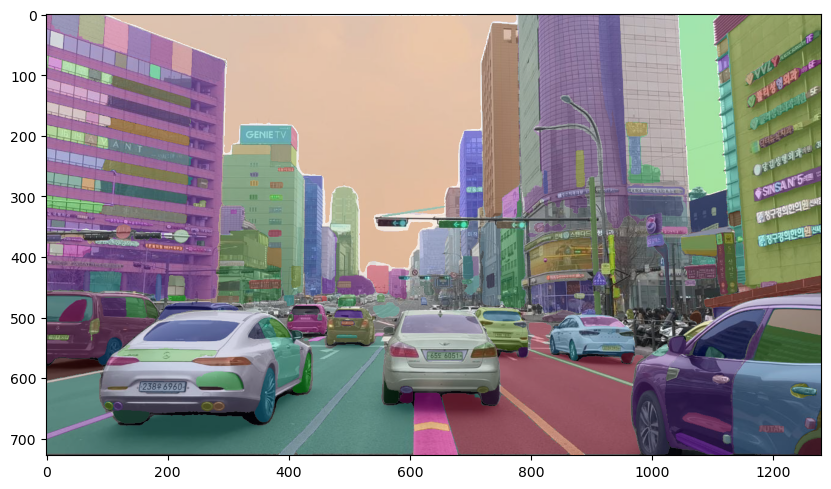

In [23]:
def show_anns(anns):
    """Takes a list of masks as an input and visualizes them on an Image"""
    if len(anns) == 0:
        return 
    
    # Sort the masks by their area in descending order
    sorted_anns=sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax=plt.gca()
    ax.set_autoscale_on(False)
    
    # let's create a new image that is the same size as the largest mask
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    """
    1st argument: sorted_anns[0]['segmentation'].shape[0] --> Height of the new image,
        2nd argument: sorted_anns[0]['segmentation'].shape[1] --> Width of the new image,
        3rd argument: specifies number of channels in new array, means each pixel in new image array will have 4 values.
    """
    
    img[:,:,3] = 0    # sets the alpha channel of the new image to 0. 
    """A value of 0 means that the pixel is completely transparent, and a value of 1 means that the pixel is completely opaque."""
    
    # Now let's iterate over a sorted masks and fills in the corresponding pixels in new image with random color.
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])    # stores a random color, that will be used to fill in the pixels in the new image.
        img[m] = color_mask
        
    ax.imshow(img)

plt.figure(figsize=(10, 10)) 
plt.imshow(image)
show_anns(masks)

# 📦️ **Now let's define a function that creates the Bounding box and label it**

In [24]:
!pip install ultralytics

In [25]:
from ultralytics import YOLO
import math

model = YOLO('yolov8n.pt')    # I am using yolo version 8 Nano weights, but one can even use Large or Medium as weights

100%|██████████| 6.23M/6.23M [00:00<00:00, 81.5MB/s]


In [26]:
# From the COCO Dataset by Microsoft, let's create a list of classes that YOLO could be able to detect
classnames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
              "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
              "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
              "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
              "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa",
              "potted plant", "bed", "dining table", "toilet", "tv monitor", "laptop", "mouse", "remote", "keyboard",
              "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"]

In [27]:
image.shape

(728, 1280, 3)


0: 384x640 9 cars, 1 traffic light, 90.7ms
Speed: 5.7ms preprocess, 90.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


x1,y1 coordinate: (964, 461)
x2,y2 coordinate: (1279, 724)
Width: 315
Height:263
Confidence of box: 0.94
 ------------------------------
x1,y1 coordinate: (87, 482)
x2,y2 coordinate: (442, 680)
Width: 355
Height:198
Confidence of box: 0.9
 ------------------------------
x1,y1 coordinate: (554, 487)
x2,y2 coordinate: (751, 649)
Width: 197
Height:162
Confidence of box: 0.89
 ------------------------------
x1,y1 coordinate: (831, 494)
x2,y2 coordinate: (973, 576)
Width: 142
Height:82
Confidence of box: 0.88
 ------------------------------
x1,y1 coordinate: (462, 485)
x2,y2 coordinate: (540, 548)
Width: 78
Height:63
Confidence of box: 0.8
 ------------------------------
x1,y1 coordinate: (710, 484)
x2,y2 coordinate: (797, 570)
Width: 87
Height:86
Confidence of box: 0.78
 ------------------------------
x1,y1 coordinate: (0, 457)
x2,y2 coordinate: (192, 581)
Width: 192
Height:124
Confidence of box: 0.68
 ------------------------------
x1,y1 coordinate: (397, 482)
x2,y2 coordinate: (467, 541)

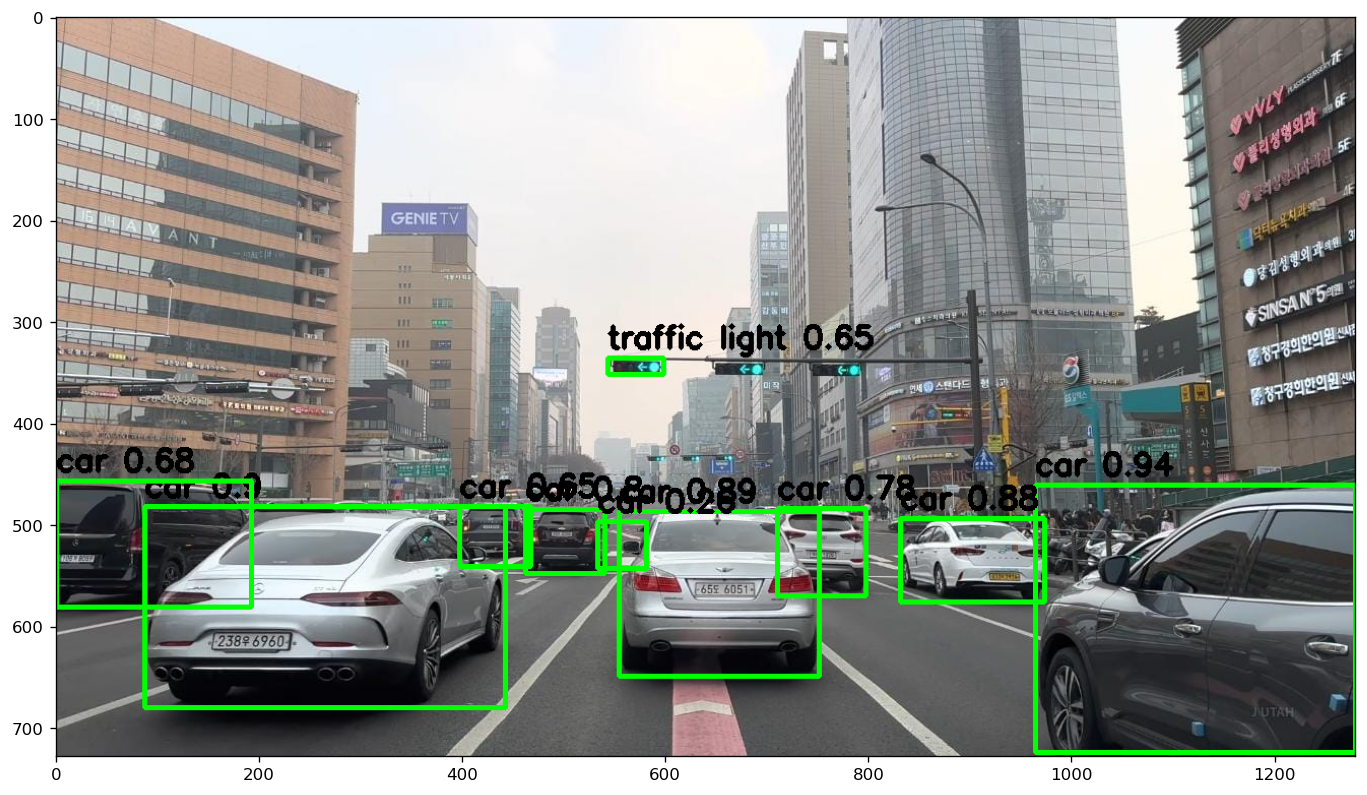

In [28]:
def show_bbox_and_label():
    results = model(image)
    
    for r in results:    # for number of OBJECTS detected in the image
        boxes = r.boxes  # give me the bounding boxes of those objects detected in the image
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2-x1, y2-y1
            print(f"x1,y1 coordinate: {(x1,y1)}\nx2,y2 coordinate: {x2,y2}\nWidth: {w}\nHeight:{h}")
            
            # Find out the confidence
            conf = math.ceil(box.conf[0]*100) / 100
            print(f"Confidence of box: {conf}\n","-"*30)
            
            # Find out the class name
            cls = int(box.cls[0])
            
            # Draw the rectangle
            cv2.rectangle(image, (x1,y1), (x2,y2), (0, 255, 0), 3)
            
            # Now, let's put the text on rectangle
            FONT = cv2.FONT_HERSHEY_SIMPLEX
            COLOR = (0, 0, 0)
            THICKNESS = 3
            ORG = (max(0, x1), max(35, y1 - 10))
            
            cv2.putText(image, str(f"{classnames[cls]} {conf}"), ORG, FONT, 1, COLOR, THICKNESS)
       
    plt.figure(figsize=(15,8), dpi=120)
    plt.imshow(image)
    
show_bbox_and_label()

# 💁🏼 **Hence we can Mask using SAM(Segment Anything Model) and provide a Bounding Box to the Detected Objects using YOLO**